In [1]:
import torch
from collections import OrderedDict

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import pickle

from scipy.interpolate import griddata
import time

np.random.seed(1)

In [2]:
def plot_3d_scatter(points):
    
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(projection="3d")
    ax.scatter(points[:,0], points[:,1], points[:,2], s=1)
    
    return fig, ax

## Overview

This jupyter notebook implements the plain time-consistent physics-informed neural network (tcPINN) idea for the Lorenz system.

The system reads

\begin{align*}
    \frac{d}{dt} \begin{pmatrix} x \\ y \\ z \end{pmatrix} = \begin{pmatrix} 
    \sigma (y-x) \\ x(\rho -z) - y \\ xy - \beta z\end{pmatrix}.
\end{align*}

We set $\sigma = 10, \beta = \frac{8}{3}$ and $\rho = 28$, which is a choice of parameters known to exhibit chaotic behavior.

We scale the ODE system to guarantee outputs on a magnitude a neural network with Tanh activation can handle gracefully. For a scaling factor $c$, the scaled Lorenz system reads

\begin{align*}
    \frac{d}{dt} \begin{pmatrix} x \\ y \\ z \end{pmatrix} = \begin{pmatrix} 
    \sigma (y-x) \\ cx(\frac{\rho}{c} -z) - y \\ cxy - \beta z\end{pmatrix}.
\end{align*}

In [3]:
sigma = 10.
beta = 8 / 3
rho = 28.

# Note: This scaling factor was used to generate the training data points
scaling_factor = 40.

In [4]:
if torch.cuda.is_available():
    device = torch.device("cuda")

else:
    device = torch.device("cpu")

In [5]:
class MLP(torch.nn.Module):
    """
    Define an multilayer perceptron (MLP) with arbitrary layers and Tanh activation. 
    In the time-consistent physics informed neural network (tcPINN) implementation,
    the inputs of the MLP will correspond to the time and the initial state (t, 𝑦0).
    """    
    def __init__(self, layers):
        """
        Build the MLP.
        
        Input:
        ------
        layers: list
            A list that specifies the number of neurons for each layer.
            Entry i of 'list' specifies the number of neurons in layer i.
        """
        super().__init__()
        self.depth = len(layers) - 1
        self.activation = torch.nn.Tanh
        
        layer_list = list()
        
        for i in range(self.depth - 1):    
            layer_list.append(
                (f"layer_{i}", torch.nn.Linear(layers[i], layers[i+1]))
            )
            layer_list.append((f"activation_{i}", self.activation()))
            
        layer_list.append(
            (f"layer_{self.depth - 1}", torch.nn.Linear(layers[-2], layers[-1]))
        )
        layerDict = OrderedDict(layer_list)
        
        self.layers = torch.nn.Sequential(layerDict)
    
    
    def forward(self, x):
        """
        Apply the neural network to the input 'x'. In the tcPINN implementation,
        'x' = (t, y0), where t is the time and y0 is the initial state.
        """
        return self.layers(x)

In [6]:
class TcPINN:
    """
    A tcPINN implementation for the (scaled) Lorenz system.
    """
    def __init__(self, layers, T, X_pinn=None, X_semigroup=None, X_smooth=None, X_data=None, data=None):
        """
        Initialize the MLP and the training data. It is possible to use a subset of the 
        four loss functions {standard PINN loss, semigroup loss, smoothness loss, data loss} by
        only providing some of the training data.
        
        Input:
        ------
        layers: list
            A list that specifies the number of neurons for each layer of the MLP.
            Entry i of 'list' specifies the number of neurons in layer i.
        
        T: float
            The supremum of all times in the training data. When predicting the solution of
            the ODE after time T, the trajectory has to be stitched together.
        
        X_pinn: np.ndarray
            The training data for the standard PINN loss. The first column of 'X_pinn'
            corresponds to the times, the other columns correspond to the intial values.
        
        X_semigroup: np.ndarray
            The training data for the semigroup loss. The first column of 'X_semigroup'
            corresponds to the length of the first time step, the second to the length of the
            second time step, and the other columns correspond to the intial values.
        
        X_smooth: np.ndarray
            The training data for the smoothness loss. The first column of 'X_smooth'
            corresponds to the times, the other columns correspond to the intial values.
        
        X_data: np.ndarray
            The training data for the data loss. The first column of 'X_data'
            corresponds to the times, the other columns correspond to the intial values.
        
        data: np.ndarray
            The measured/true values of the ODE for the times and initial values given by
            'X_data'.
        """
        self.mlp = MLP(layers).to(device)
        self.ode_dimension = layers[-1]
        
        self.optimizer = torch.optim.LBFGS(
            self.mlp.parameters(), lr=1., max_iter=50000, max_eval=50000, 
            history_size=10, tolerance_grad=1e-5, tolerance_change=np.finfo(float).eps, 
            line_search_fn="strong_wolfe"
        )
        self.scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            self.optimizer, mode='min', min_lr=1e-4, verbose=True
        )
        self.iter = 0
        
        self.T = torch.tensor(T).float().to(device)
        self._init_training_data(X_pinn, X_semigroup, X_smooth, X_data, data)
    
    
    def _init_training_data(self, X_pinn, X_semigroup, X_smooth, X_data, data):
        
        if X_pinn is not None:
            self.t_pinn = torch.tensor(X_pinn[:, :1], requires_grad=True).float().to(device)
            self.y_pinn = torch.tensor(X_pinn[:, 1:], requires_grad=True).float().to(device)
            self.use_standard = True
        
        else:
            self.use_standard = False
        
        if X_semigroup is not None:
            self.s_semigroup = torch.tensor(X_semigroup[:, :1], requires_grad=True).float().to(device)
            self.t_semigroup = torch.tensor(X_semigroup[:, 1:2], requires_grad=True).float().to(device)
            self.y_semigroup = torch.tensor(X_semigroup[:, 2:], requires_grad=True).float().to(device)
            self.use_semigroup = True
        
        else:
            self.use_semigroup = False
        
        if X_smooth is not None:
            self.t_smooth = torch.tensor(X_smooth[:, :1], requires_grad=True).float().to(device)
            self.y_smooth = torch.tensor(X_smooth[:, 1:], requires_grad=True).float().to(device)
            self.use_smooth = True
        
        else:
            self.use_smooth = False
        
        if X_data is not None:
            if data is None:
                raise ValueError("The true/measured solution for the 'X_data' points has to be provided.")
            self.t_data = torch.tensor(X_data[:, :1], requires_grad=True).float().to(device)
            self.y_data = torch.tensor(X_data[:, 1:], requires_grad=True).float().to(device)
            self.data = torch.tensor(data, requires_grad=True).float().to(device)
            self.use_data = True
        
        else:
            self.use_data = False
    
    
    def net_y(self, t, y0):
        """
        Let N(t, y0) denote the value of the MLP at time t for initial value y0.
        Let M(t, y0) denote the value of the tcPINN at time t for initial value y0.
        
        We set M(t, y0) = y0 + t * N(t, y0) to guarantee continuity of the trajectory
        when stitching together solutions for large times.
        """
        y = y0 + t * self.mlp(torch.cat([t, y0], dim=1))
        
        return y
    
    
    def net_derivative(self, t, y0):
        """
        Pytorch automatic differentiation to compute the derivatives of the neural network
        with respect to time.
        
        Output:
        -------
        derivatives: list
            The i-th entry is the time derivative of the i-th output component of the neural network
            evaluated at all inputs (t, y0). Each input corresponds to one row in each tensor.
        """
        y = self.net_y(t, y0)
        
        # vectors for the autograd vector Jacobian product 
        # to compute the derivatives w.r.t. every output component
        vectors = [torch.zeros_like(y) for _ in range(self.ode_dimension)]
        
        for i, vec in enumerate(vectors):
            vec[:,i] = 1.
        
        derivatives = [
            torch.autograd.grad(
                y, t, 
                grad_outputs=vec,
                retain_graph=True,
                create_graph=True
            )[0]
            for vec in vectors
        ]
        
        return derivatives
    
    
    def _loss_pinn(self):
        """
        The ODE-specific standard PINN loss.
        """
        y = self.net_y(self.t_pinn, self.y_pinn)
        deriv = self.net_derivative(self.t_pinn, self.y_pinn)
        
        loss1 = torch.mean((deriv[0] - sigma * (y[:,1:2] - y[:,0:1])) ** 2)
        loss2 = torch.mean((deriv[1] - scaling_factor * y[:,0:1] * (rho / scaling_factor - y[:,2:3]) + y[:,1:2]) ** 2)
        loss3 = torch.mean((deriv[2] - scaling_factor * y[:,0:1] * y[:,1:2] + beta * y[:,2:3]) ** 2)
        
        loss = loss1 + loss2 + loss3
        
        return loss
    
    
    def _loss_semigroup(self):
        """
        The general semigroup loss.
        """
        y_no_restart = self.net_y(self.s_semigroup + self.t_semigroup, self.y_semigroup)
        y_s = self.net_y(self.s_semigroup, self.y_semigroup)
        y_restart = self.net_y(self.t_semigroup, y_s)
        loss = self.ode_dimension * torch.mean((y_no_restart - y_restart) ** 2)
        
        return loss
    
    
    def _loss_smooth(self):
        """
        The general smoothness loss.
        """
        deriv_below = self.net_derivative(self.t_smooth, self.y_smooth)
        y = self.net_y(self.t_smooth, self.y_smooth)
        deriv_above = self.net_derivative(torch.zeros_like(self.t_smooth, requires_grad=True), y)
        
        loss = .0
        
        for d1, d2 in zip(deriv_below, deriv_above):
            loss += torch.mean((d1 - d2) ** 2)
        
        return loss
    
    
    def _loss_data(self):
        """
        The general data loss.
        """
        y = self.net_y(self.t_data, self.y_data)
        loss = self.ode_dimension * torch.mean((y - self.data) ** 2)
        
        return loss
    
    
    def loss_function(self):
        
        self.optimizer.zero_grad()
        
        loss = .0
        
        if self.use_standard:
            loss_pinn = self._loss_pinn()
            loss += loss_pinn
        
        if self.use_semigroup:
            loss_semigroup = self._loss_semigroup()
            loss += loss_semigroup
        
        if self.use_smooth:
            loss_smooth = self._loss_smooth()
            loss += loss_smooth
        
        if self.use_data:
            loss_data = self._loss_data()
            loss += loss_data
        
        loss.backward()
        self.scheduler.step(loss)
        self.iter += 1
        
        if self.iter % 10 == 0:
            info = f"iteration {self.iter}, loss: {loss.item():.4f}"
            
            if self.use_standard:
                info += f", PINN loss: {loss_pinn.item():.4f}"
            
            if self.use_semigroup:
                info += f", semigroup loss: {loss_semigroup.item():.4f}"
            
            if self.use_smooth:
                info += f", smoothness loss: {loss_smooth.item():.4f}"
            
            if self.use_data:
                info += f", data loss: {loss_data.item():.4f}"
            
            print(info)
        
        return loss    
    
    
    def train(self):
        """
        Train the MLP parameters with the LBFGS optimizer.
        """
        self.mlp.train()
        self.optimizer.step(self.loss_function)
    
    
    def predict(self, t, y0):
        """
        Evaluate the tcPINN at times 't' for initial values 'y0'.
        Each row (!) in 't' and 'y0' is one time point and intial value, respectively.
        """
        t = torch.tensor(t).float().to(device)
        y0 = torch.tensor(y0).float().to(device)
        
        self.mlp.eval()
        prediction = self.net_y(t, y0)
        prediction = prediction.detach().cpu().numpy()
        
        return prediction
    
    
    def predict_standard(self, max_t, delta_t, y0):
        """
        Predict the solution until time 'max_t' with step size 'delta_t' for
        a single (!) initial value 'y0'.
        
        The tcPINN is not (!) applied multiple times to stitch together trajectories.
        The predicted trajectory will therefore most likely be incorrect for all times 
        t > self.T.
        """        
        times = np.linspace(0, max_t, int(max_t / delta_t) + 1)
        times = times[:, np.newaxis]
        y0s = np.repeat(y0[np.newaxis,:], len(times), axis=0)
        
        trajectory = self.predict(times, y0s)
        
        return trajectory
    
    
    def predict_tc(self, max_t, delta_t, y0):
        """
        Predict the solution until time 'max_t' with step size 'delta_t' for
        a single (!) initial value 'y0'.
        
        The tcPINN is applied multiple times to stitch together trajectories.
        """
        times = np.arange(0, self.T + delta_t, delta_t)[1:]
        times = times[:, np.newaxis]
        n_resets = int(np.ceil(max_t / self.T))
        
        trajectory = np.array([y0])
        
        for _ in range(n_resets):
            
            y0 = trajectory[-1]
            y0s = np.repeat(y0[np.newaxis,:], len(times), axis=0)
            segment =  self.predict(times, y0s)
            trajectory = np.vstack([trajectory, segment])
        
        return trajectory

### Setup Training Data

In [7]:
n_points_file = 100000

with open(f"init_values_{n_points_file}.npy", "rb") as f:
    init_values = np.load(f)

In [8]:
def sample_points_lorenz(n_points):
    
    n_init_values = len(init_values)
    n_points = min(n_points, n_init_values)
    indices = np.random.choice(np.arange(n_init_values), n_points)
    
    return init_values[indices, :]


def sample_triangle_2d(n_samples, side_length):
    """
    Sample 'n_samples' points from the triangle with corners 
    (0,0), ('side_length', 0) and (0, 'side_length').
    """
    r1 = np.random.uniform(0, 1, size=n_samples)
    r2 = np.random.uniform(0, 1, size=n_samples)
    
    y0 = np.sqrt(r1) * (1 - r2)
    y1 = r2 * np.sqrt(r1)
    
    y0 *= side_length
    y1 *= side_length
    points = np.stack([y0, y1], axis=0).T
    
    return points

In [9]:
layers = [4] + 10 * [64] + [3]
T = .1

# standard PINN loss function training samples
n_pinn = 10000
t_pinn = np.random.uniform(0, T, (n_pinn, 1))
y_pinn = sample_points_lorenz(n_pinn)
X_pinn = np.hstack([t_pinn, y_pinn])


n_semigroup = 10000
st_semigroup = sample_triangle_2d(n_semigroup, T)
y_semigroup = sample_points_lorenz(n_semigroup)
X_semigroup = np.hstack([st_semigroup, y_semigroup])

n_smooth = 10000
t_smooth = np.random.uniform(0, T, (n_smooth, 1))
y_smooth = sample_points_lorenz(n_smooth)
X_smooth = np.hstack([t_smooth, y_smooth])

with open("./X_pinn_lorenz.pkl", "wb") as handle:
    pickle.dump(X_pinn, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open("./X_semigroup_lorenz.pkl", "wb") as handle:
    pickle.dump(X_semigroup, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open("./X_smooth_lorenz.pkl", "wb") as handle:
    pickle.dump(X_smooth, handle, protocol=pickle.HIGHEST_PROTOCOL)

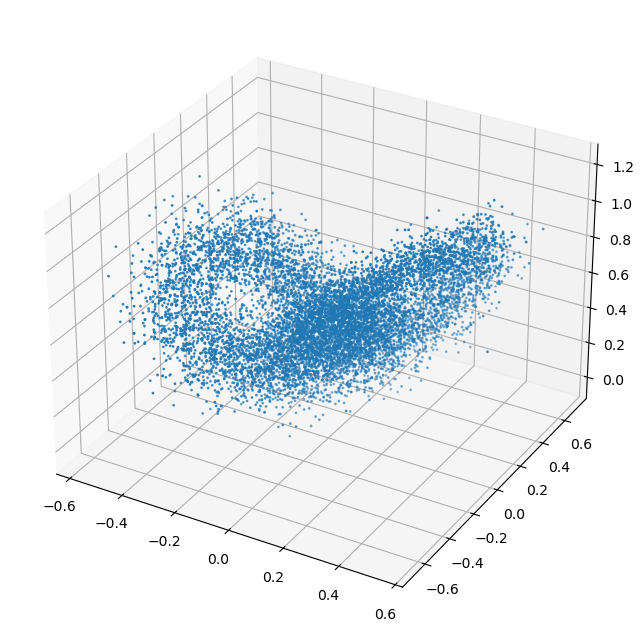

In [10]:
fig, ax = plot_3d_scatter(X_smooth[:, 1:])
plt.show()

In [11]:
model = TcPINN(layers, T, X_pinn=X_pinn, X_semigroup=X_semigroup, X_smooth=X_smooth)

In [12]:
%%time
               
model.train()

iteration 10, loss: 8.8189, PINN loss: 8.8189, semigroup loss: 0.0000, smoothness loss: 0.0001
iteration 20, loss: 7.6386, PINN loss: 7.5247, semigroup loss: 0.0000, smoothness loss: 0.1139
iteration 30, loss: 6.1266, PINN loss: 6.1009, semigroup loss: 0.0000, smoothness loss: 0.0256


KeyboardInterrupt: 

In [13]:
with open("./model_lorenz.pkl", "wb") as handle:
    pickle.dump(model, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open("./model_lorenz.pkl", "rb") as f:
    model = pickle.load(f)

## Predict and Plot the Solution

In [15]:
def plot_3d_curve(sol):
    
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(projection="3d")
    ax.plot(sol[:, 0], sol[:, 1], sol[:, 2], lw=1)
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")
    
    return fig, ax

In [16]:
# Note that max_t in training is .1
y0 = init_values[0]

max_t_pred = 10.
delta_t = 0.01

validation_tc = model.predict_tc(max_t_pred, delta_t, y0)

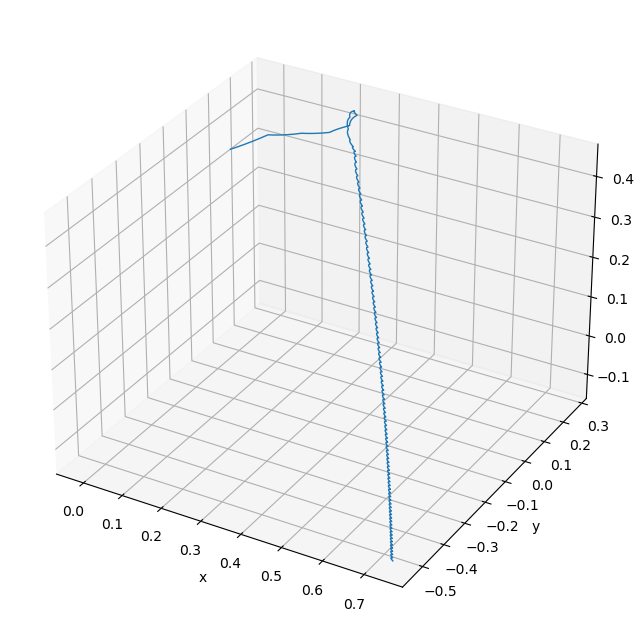

In [17]:
fig, ax = plot_3d_curve(validation_tc)

plt.savefig("lorenz_system.pdf", bbox_inches="tight")
plt.show()